# HA haplotype analysis show transmission bottlenecks are stringent 
  
**Author**: Katarina Braun 

## Overview
- The purpose of this script is to take collated bam files (generated from `Sniffles`), convert to a SAM file to extract the HA-only alignments, then convert back to BAM, use `Samtools` to sort, then mine the reads for linkage patterns at a predefined list of sites. 
- This script mines HA for linkage patterns across frequently-identified SNVs (documented below).  
- Here are the H7N9 sites I am going to use (based on SNVs that are frequently detected): 
    1. 410 (AA 137) 
    2. 421 (AA 141) 
    3. 427 (AA 143)
    4. 499 (AA 167) 
    5. 519 (AA 173) 
    6. 580 (AA 194) 
    7. 667 (AA 223) 
    8. 683 (AA 228) 
    9. 704 (AA 235) 
    10. 859 (AA 287) ** I've tried +/- with this position. There are a few reads that cover all of these positions, but not many. Available haplotype diversity is much higher when I exclude this site so that is what I'll do for the moment.
- Here are the H1N1pdm sites I am going to use (based on SNVs that are frequently detected): 
    1. 432 
    2. 436
    3. 442
    4. 515
    5. 598
    6. 622
    7. 635
    8. 640
    9. 677
    
### Note about HA numbering: 
For H7N9, I used H7 numbering. This numbering scheme matches the numbering scheme on Nextstrain (https://nextstrain.org/).  
For H1N1pdm, I use H1 numbering. Again, this numbering scheme matches the numbering scheme on Nextstrain. For clarity, I start counting amino acids at nucleotide #51, AA #18 (D). 

**Colors**: (hex codes) 
1. **GD3 and recombinant viruses**: #264653
2. **Anhui**: #2A9D8F
3. **CA04**: #F4A261

## Input: 

Collated bam files, which can be found here: 


## Output: 

LinkGe csv(.txt) file containing
- input nucleotide positions
- number of associated reads per haplotype
- haplotype frequency, expressed as a decimal 
- number of haplotypes = number of lines (number of lines in the file - three header lines) in this file 

These files can be found here: 

In addition, the script generates barplots (stacked area barplots) which contain the number of haplotypes at each timepoint before and after tranmission. 

These files can be found here: 

## for ease of use, here is a table summarizing the transmission pair available data 

### Index ferrets 

| Ferret ID | Virus | Day 1 | Day 3 | Day 5 | Day 7 |
| - | - | - | - | - | - |
|3|Guangdong/17SF003|x|x|x|x|
|9|R294-Guangdong|x|x|x|x|
|11|R294-Guangdong|x|x|
|15|R294-Guangdong|x|x|x|x|
|17|K294-Guangdong|x|x|x|x|
|21|K294-Guangdong|x|x|x|
|23|K294-Guangdong|x|x|x|x|
|27|Anhui1|x|x|x|x|
|35|CA04|x|x|x|

### Contact ferrets 

| Ferret ID | Virus | Day 3 | Day 5 | Day 7 | Day 9 | Day 11 | Day 13 | Day 15 |
| - | - | - | - | - | - | -|-|-|
|4|Guangdong/17SF003|-|x|x|x|x|
|10|R294-Guangdong|x|x|x|x|
|12|R294-Guangdong|x|x|
|16|R294-Guangdong|x|x|x|
|18|K294-Guangdong|-|-|-|-|x|x|x|
|22|K294-Guangdong|x|x|x|x|
|24|K294-Guangdong|
|28|Anhui1|x|x|x|
|36|CA04|x|x|

### Ferret pairs, timepoints closest to time of transmission 
| Ferret pair ID | Index ID | Contact ID | Virus | transmission timepoint #1 (index) | transmission timepoint #2 (contact) | 
| - | - | - | - | - | - | 
|1|3|4|Guangdong/17SF003|DPI 3| DPI 5|
|2|9|10|R294-Guangong|DPI 1| DPI 3|
|3|11|12|R294-Guangong|DPI 1| DPI 3|
|4|15|16|R294-Guangong|DPI 1| DPI 3|
|5|17|18|K294-Guangong|DPI 7| DPI 11|
|6|21|22|K294-Guangong|DPI 1| DPI 3|
|7|27|28|Anhui1|DPI 1| DPI 3|
|8|35|36|CA04|DPI 1| DPI 3|

### import modules and dependencies

In [10]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches
import random 
from pylab import *
from matplotlib.font_manager import FontProperties 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

### These scripts were used to convert the collated bams to sam files, splice HA reads out of the SAM files, then convert these HA-only SAM files back into bam files, which can be used as input for the LinkGe.pl script

The code used to do this can be found below, but all of input / output files to do so can be found `H7N9-evolution-in-mammals/data_derived/haplotypes/*`, so this code does not need to be run again. 

I am include this code here so it is clear how I manipulated the collated bam files. 

```bash
# convert this BAM to a SAM file 
inpath="../data_derived/haplotypes/CA04_ferret36_day3.bam"
outpath="../data_derived/haplotypes/CA04_ferret36_day3_whole-genome.sam"

/Users/katbraun/anaconda3/bin/reformat.sh \ # path to the reformat.sh script
'sam=1.3' \
in=$inpath \
out=$outpath

### new cell 

inpath="../data_derived/haplotypes/CA04_ferret36_day3_whole-genome.sam" 
outpath="../data_derived/haplotypes/CA04_ferret36_day3_HA.sam"

#make a new SAM file with HA contigs only 
# grep '@HD\|@SQ\tSN:A_GUANGDONG_17SF003_2016_H7\|@PG\tID:bowtie2\t\|A_GUANGDONG_17SF003_2016_H7' $inpath > $outpath
grep '@HD\|@SQ\tSN:A_CALIFORNIA_04_2009_H1\|@PG\tID:bowtie2\t\|A_CALIFORNIA_04_2009_H1' $inpath > $outpath


### new cell

# convert the HA SAM back into a BAM file 
inpath="../data_derived/haplotypes/CA04_ferret36_day3_HA.sam"
outpath="../data_derived/haplotypes/CA04_ferret36_day3_HA.bam"

/Users/katbraun/anaconda3/bin/reformat.sh \ # path to reformat.sh
'sam=1.3' \
in=$inpath \
out=$outpath

### new cell 

# sort the bam alignment 
inpath="../data_derived/haplotypes/CA04_ferret36_day3_HA.bam"
outpath="../data_derived/haplotypes/CA04_ferret36_day3_HA-sorted.bam"

/Users/katbraun/anaconda3/bin/samtools \ # path to samtools
sort -o $outpath $inpath

### new cell

# run LinkGe on paired-merged-aligned-sorted.bam at
# output 1: csv with barcode sequence, reads per barcodes sequence, and frequency 

outfile="../data_derived/haplotypes/CA04_ferret36_day3_HA_haplotypes"
inpath="../data_derived/haplotypes/CA04_ferret36_day3_HA-sorted.bam"
Linkge="LinkGe.pl"

/Users/katbraun/anaconda3/envs/myperl/bin/perl \
$Linkge -o $outfile -l 432,436,442,515,598,622,635,640,677 $inpath # CA04 #51 nucleotide numbering
# $Linkge -o $outfile -l 410,421,427,499,519,580,667,683,704 $inpath # GD3 and Anhui
# $Linkge -o $outfile -l 381,385,391,464,547,571,584,589,626 $inpath # CA04
# $Linkge -o $outfile -l 432,436,442,515,598,622,635,640,677 $inpath # CA04 #51 nucleotide numbering

### new cell

# delete sam and bam files in the data_derived/haplotype directory 
# I only need to save the LinkGe output text files, which contain haplotype identities, frequencies, and counts
rm '../data_derived/haplotypes/*.sam'
rm '../data_derived/haplotypes/*.bam'
rm '../data_derived/haplotypes/*.bai'

```


## Use the data generated above to evalute the number and frequency of HA haplotypes before and after transmission events 

### Define functions I will use to load and merge haplotypes 

In [84]:
def load_haplotypes(ferret): # input = strings with virus_ferretID_day
    DF = pd.read_csv('../data_derived/haplotypes/' + ferret + '_HA_haplotypes.txt', skiprows=3, sep='\t', header=None,names=['haplotype', 'read_support', 'frequency'])
    DF = DF[['haplotype','frequency']]
    print(DF['frequency'].sum()) # should be close to 1 (100%)
    return(DF)

def merge_haplotypes(index_DF, contact_DF, color): # input = dataframes generated above # color = matplotlib color map, string
    len_index = len(index_DF)
    len_contact = len(contact_DF)
    merged = index_DF.merge(contact_DF, on='haplotype', how='outer')
    merged['frequency_index'] = merged['frequency_x'] # frequency_x = index frequncies 
    merged['frequency_contact'] = merged['frequency_y']
    merged.sort_values('frequency_index', ascending=False, inplace=True) 
    merged = merged.replace(np.nan, 0, regex=True) # replace NaN with zeroes
    num_colors = len(merged) #establish color palette and the number of colors that will be needed to plot timeseries data
    color_list = sns.color_palette(color, num_colors).as_hex()
    merged['colors'] = list(color_list)
    merged['haplotype_index'] = merged['haplotype']
    merged['haplotype_contact'] = merged['haplotype']
    merged['proportion_index'] = merged['frequency_index'] * len_index
    merged['proportion_contact'] = merged['frequency_contact'] * len_contact
    merged = merged[['haplotype_index', 'frequency_index', 'proportion_index', 'haplotype_contact', 'frequency_contact', 'proportion_contact', 'colors']]
    index = merged[['haplotype_index', 'frequency_index', 'proportion_index']]
    contact = merged[['haplotype_contact',  'frequency_contact', 'proportion_contact']]
#     print(num_haplotypes)
    return(index, contact, merged)

In [85]:
# load all dataframes with load_haplotypes function
# this function will print the sum of all haplotype frequencies -- do not proceed unless these numbers are all close to one

GD3_ferret3_day3 = load_haplotypes('GD3_ferret3_day3')
GD3_ferret4_day5 = load_haplotypes('GD3_ferret4_day5')
GD3_ferret9_day1 = load_haplotypes('GD3_ferret9_day1')
GD3_ferret10_day3 = load_haplotypes('GD3_ferret10_day3')
GD3_ferret11_day1 = load_haplotypes('GD3_ferret11_day1')
GD3_ferret12_day3 = load_haplotypes('GD3_ferret12_day3')
GD3_ferret15_day1 = load_haplotypes('GD3_ferret15_day1')
GD3_ferret16_day3 = load_haplotypes('GD3_ferret16_day3')
GD3_ferret17_day7 = load_haplotypes('GD3_ferret17_day7')
GD3_ferret18_day11 = load_haplotypes('GD3_ferret18_day11')
GD3_ferret21_day1 = load_haplotypes('GD3_ferret21_day1')
GD3_ferret22_day3 = load_haplotypes('GD3_ferret22_day3')
Anhui_ferret27_day1 = load_haplotypes('Anhui_ferret27_day1')
Anhui_ferret28_day3 = load_haplotypes('Anhui_ferret28_day3')
CA04_ferret35_day1 = load_haplotypes('CA04_ferret35_day1')
CA04_ferret36_day3 = load_haplotypes('CA04_ferret36_day3')



1.0000003999999996
0.9999996
0.9999998999999999
0.9999999
1.0000004999999998
0.9999998999999999
1.0000000999999998
0.9999999000000002
1.0000000999999998
0.9999998999999999
1.0000003
0.9999999000000002
0.9999987999999996
1.0000000999999998
1.0000013
0.9999996999999999


In [108]:
# merge all pairs of haplotypes across the transmission bottleneck and save each dataframe under it's own name (index and contact)

pair1 = merge_haplotypes(GD3_ferret3_day3, GD3_ferret4_day5, 'Dark2')
pair1_index = pair1[0]
pair1_contact = pair1[1]
pair1_merged = pair1[2]
pair1_merged_prop = pair1_merged[['proportion_index', 'proportion_contact']]
pair1_merged_prop_T = pair1_merged_prop.T

pair2 = merge_haplotypes(GD3_ferret9_day1, GD3_ferret10_day3, 'Dark2')
pair2_index = pair2[0]
pair2_contact = pair2[1]
pair2_merged = pair2[2]
pair2_merged_prop = pair2_merged[['proportion_index', 'proportion_contact']]
pair2_merged_prop_T = pair2_merged_prop.T

pair3 = merge_haplotypes(GD3_ferret11_day1, GD3_ferret12_day3, 'Dark2')
pair3_index = pair3[0]
pair3_contact = pair3[1]
pair3_merged = pair3[2]
pair3_merged_prop = pair3_merged[['proportion_index', 'proportion_contact']]
pair3_merged_prop_T = pair3_merged_prop.T

pair4 = merge_haplotypes(GD3_ferret15_day1, GD3_ferret16_day3, 'Dark2')
pair4_index = pair4[0]
pair4_contact = pair4[1]
pair4_merged = pair4[2]
pair4_merged_prop = pair4_merged[['proportion_index', 'proportion_contact']]
pair4_merged_prop_T = pair4_merged_prop.T

pair5 = merge_haplotypes(GD3_ferret17_day7, GD3_ferret18_day11, 'Dark2')
pair5_index = pair5[0]
pair5_contact = pair5[1]
pair5_merged = pair5[2]
pair5_merged_prop = pair5_merged[['proportion_index', 'proportion_contact']]
pair5_merged_prop_T = pair5_merged_prop.T

pair6 = merge_haplotypes(GD3_ferret21_day1, GD3_ferret22_day3, 'Dark2')
pair6_index = pair6[0]
pair6_contact = pair6[1]
pair6_merged = pair6[2]
pair6_merged_prop = pair6_merged[['proportion_index', 'proportion_contact']]
pair6_merged_prop_T = pair6_merged_prop.T

pair7 = merge_haplotypes(Anhui_ferret27_day1, Anhui_ferret28_day3, 'tab10')
pair7_index = pair7[0]
pair7_contact = pair7[1]
pair7_merged = pair7[2]
pair7_merged_prop = pair7_merged[['proportion_index', 'proportion_contact']]
pair7_merged_prop_T = pair7_merged_prop.T

pair8 = merge_haplotypes(CA04_ferret35_day1, CA04_ferret36_day3, 'tab20c')
pair8_index = pair8[0]
pair8_contact = pair8[1]
pair8_merged = pair8[2]
pair8_merged_prop = pair8_merged[['proportion_index', 'proportion_contact']]
pair8_merged_prop_T = pair8_merged_prop.T


##

## generate a stacked bar plot for each transmission pair 

### 3 transmission pairs

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


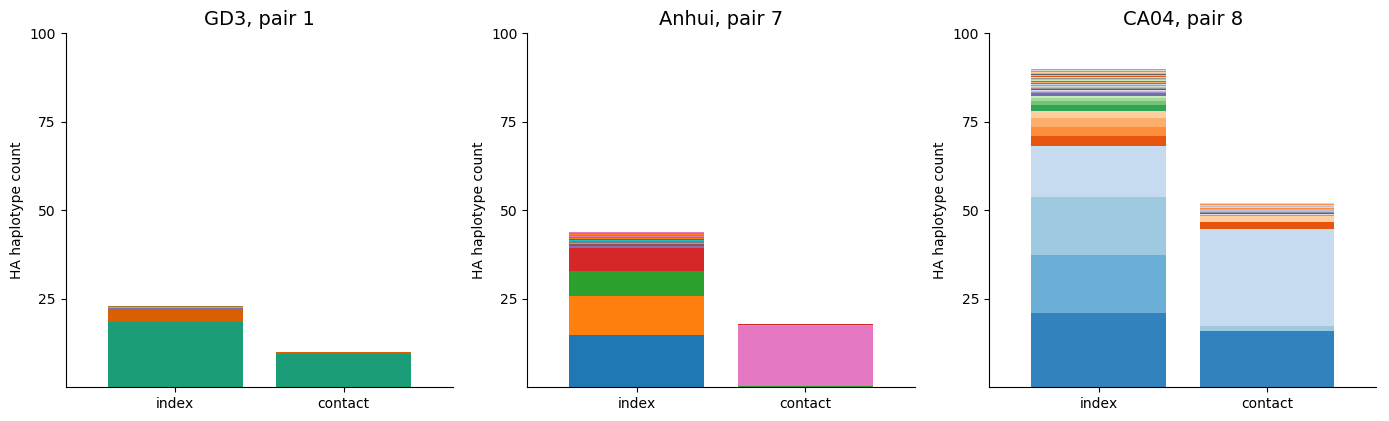

In [109]:
# define hex colors
GD3 = '#08367F'
Anhui = '#2A9D8F'
CA04 = '#F4A261'

# generate a figure with sub-plots (one for each gene segment)
fig5 = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Helvetica')
gs = gridspec.GridSpec(2, 9)

ax1 = fig5.add_subplot(gs[0,0:3]) #pair1
ax7 = fig5.add_subplot(gs[0,3:6]) #pair7
ax8 = fig5.add_subplot(gs[0,6:9]) #pair8

# get right of top and right frame of each subplot
axes = (ax1, ax7, ax8)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    
# Pair1
ax1.set_title('GD3, pair 1', fontname='Helvetica', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Helvetica")
ax1.set_ylim(0,100)
ax1.set_yticks([25,50,75,100])
ax1.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair1_merged_prop_T.plot.bar(stacked=True, width=0.8, color=pair1_merged['colors'], legend=False, ax=ax1)
ax1.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair7
ax7.set_title('Anhui, pair 7', fontname='Helvetica', fontsize=14)
ax7.set_facecolor('white')
for tick in ax7.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax7.get_yticklabels():
    tick.set_fontname("Helvetica")
ax7.set_ylim(0,100)
ax7.set_yticks([25,50,75,100])
ax7.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair7_merged_prop_T.plot.bar(stacked=True, width=0.8, color=pair7_merged['colors'], legend=False, ax=ax7)
ax7.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair8
ax8.set_title('CA04, pair 8', fontname='Helvetica', fontsize=14)
ax8.set_facecolor('white')
for tick in ax8.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax8.get_yticklabels():
    tick.set_fontname("Helvetica")
ax8.set_ylim(0,100)
ax8.set_yticks([25,50,75,100])
ax8.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair8_merged_prop_T.plot.bar(stacked=True, width=0.8, color=pair8_merged['colors'], legend=False, ax=ax8)
ax8.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# add a legend to this plot (none at the moment)

# use tight_layout to optimize spacing of axes and titles within each subplot
fig5.tight_layout()
fig5.show()

# save this plot to the figures folder 
fig5.savefig("../figures/figure5.pdf", bbox_inches='tight', dpi=300)


### All 8 transmission events 

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


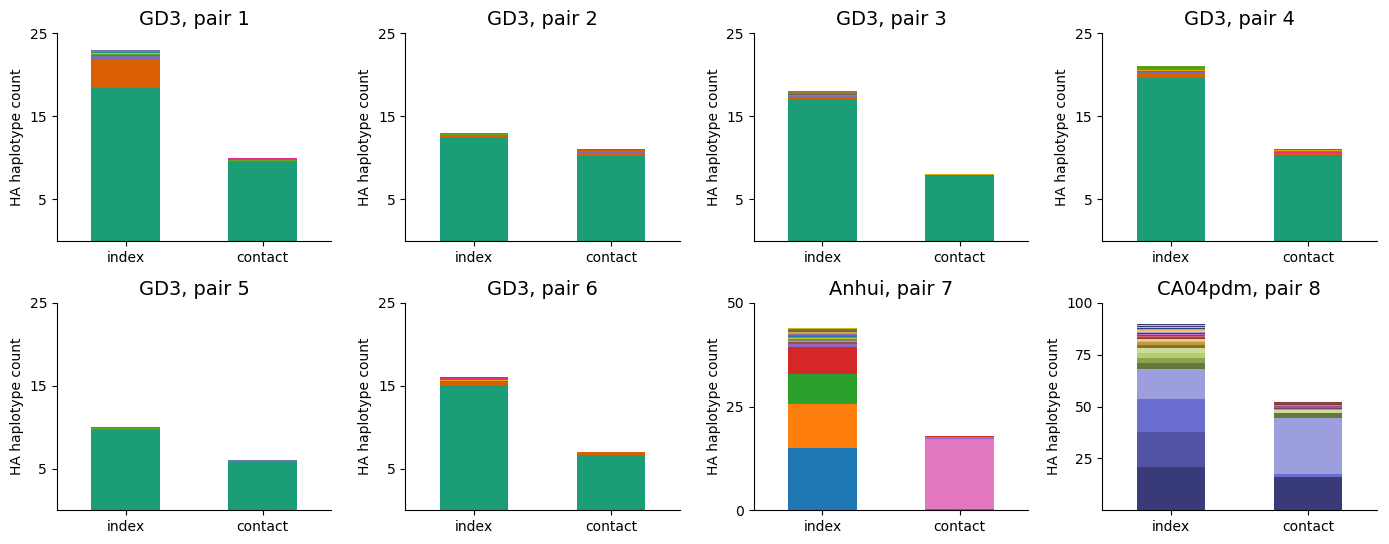

In [105]:
# define hex colors
GD3 = '#08367F'
Anhui = '#2A9D8F'
CA04 = '#F4A261'

# generate a figure with sub-plots (one for each gene segment)
fig5 = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Helvetica')
gs = gridspec.GridSpec(3, 12)

ax1 = fig5.add_subplot(gs[0,0:3]) #pair1
ax2 = fig5.add_subplot(gs[0,3:6]) #pair2
ax3 = fig5.add_subplot(gs[0,6:9]) #pair3
ax4 = fig5.add_subplot(gs[0,9:12]) #pair4
ax5 = fig5.add_subplot(gs[1,0:3]) #pair5
ax6 = fig5.add_subplot(gs[1,3:6]) #pair6
ax7 = fig5.add_subplot(gs[1,6:9]) #pair7
ax8 = fig5.add_subplot(gs[1,9:12]) #pair8

# get right of top and right frame of each subplot
axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    
# Pair1
ax1.set_title('GD3, pair 1', fontname='Helvetica', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Helvetica")
ax1.set_ylim(0,25)
ax1.set_yticks([5,15,25])
ax1.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair1_merged_prop_T.plot.bar(stacked=True, color=pair1_merged['colors'], legend=False, ax=ax1)
ax1.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair2
ax2.set_title('GD3, pair 2', fontname='Helvetica', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Helvetica")
ax2.set_ylim(0,25)
ax2.set_yticks([5,15,25])
ax2.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair2_merged_prop_T.plot.bar(stacked=True, color=pair2_merged['colors'], legend=False, ax=ax2)
ax2.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair3
ax3.set_title('GD3, pair 3', fontname='Helvetica', fontsize=14)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Helvetica")
ax3.set_ylim(0,25)
ax3.set_yticks([5,15,25])
ax3.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair3_merged_prop_T.plot.bar(stacked=True, color=pair3_merged['colors'], legend=False, ax=ax3)
ax3.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair4
ax4.set_title('GD3, pair 4', fontname='Helvetica', fontsize=14)
ax4.set_facecolor('white')
for tick in ax4.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Helvetica")
ax4.set_ylim(0,25)
ax4.set_yticks([5,15,25])
ax4.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair4_merged_prop_T.plot.bar(stacked=True, color=pair4_merged['colors'], legend=False, ax=ax4)
ax4.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair5
ax5.set_title('GD3, pair 5', fontname='Helvetica', fontsize=14)
ax5.set_facecolor('white')
for tick in ax5.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax5.get_yticklabels():
    tick.set_fontname("Helvetica")
ax5.set_ylim(0,25)
ax5.set_yticks([5,15,25])
ax5.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair5_merged_prop_T.plot.bar(stacked=True, color=pair5_merged['colors'], legend=False, ax=ax5)
ax5.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair6
ax6.set_title('GD3, pair 6', fontname='Helvetica', fontsize=14)
ax6.set_facecolor('white')
for tick in ax6.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax6.get_yticklabels():
    tick.set_fontname("Helvetica")
ax6.set_ylim(0,25)
ax6.set_yticks([5,15,25])
ax6.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair6_merged_prop_T.plot.bar(stacked=True, color=pair6_merged['colors'], legend=False, ax=ax6)
ax6.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair7
ax7.set_title('Anhui, pair 7', fontname='Helvetica', fontsize=14)
ax7.set_facecolor('white')
for tick in ax7.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax7.get_yticklabels():
    tick.set_fontname("Helvetica")
ax7.set_ylim(0,50)
ax7.set_yticks([0,25,50])
ax7.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair7_merged_prop_T.plot.bar(stacked=True, color=pair7_merged['colors'], legend=False, ax=ax7)
ax7.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# Pair8
ax8.set_title('CA04pdm, pair 8', fontname='Helvetica', fontsize=14)
ax8.set_facecolor('white')
for tick in ax8.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax8.get_yticklabels():
    tick.set_fontname("Helvetica")
ax8.set_ylim(0,100)
ax8.set_yticks([25,50,75,100])
ax8.set_ylabel('HA haplotype count', fontname='Helvetica', fontsize=10)
pair8_merged_prop_T.plot.bar(stacked=True, color=pair8_merged['colors'], legend=False, ax=ax8)
ax8.set_xticklabels(['index', 'contact'], fontname='Helvetica', fontsize='10', minor=False, rotation=0)

# add a legend to this plot
# GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous SNVs')

# fig2.legend(handles=[GD3_syn, GD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn, line], frameon=False, fontsize=14, bbox_to_anchor=(1.29,0.75))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig5.tight_layout()
fig5.show()

# save this plot to the figures folder 
# fig5.savefig("../figures/figure5.pdf", bbox_inches='tight', dpi=300)


##